In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thanjavur-dataset/updated_dataset .csv


# WITHOUT FEATURE SELECTION

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5880/5880 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8098 - loss: 0.7085 - val_accuracy: 0.8554 - val_loss: 0.3975
Epoch 2/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8500 - loss: 0.4104 - val_accuracy: 0.8687 - val_loss: 0.3722
Epoch 3/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8568 - loss: 0.3864 - val_accuracy: 0.8709 - val_loss: 0.3520
Epoch 4/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8604 - loss: 0.3757 - val_accuracy: 0.8628 - val_loss: 0.3595
Epoch 5/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8617 - loss: 0.3703 - val_accuracy: 0.8719 - val_loss: 0.3425
Epoch 6/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8637 - loss: 0.3638 - val_accuracy: 0.8729 - val_loss: 0.3424
Epoch 7/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8640 - loss: 0.3611 - val_accuracy: 0.8719 - val_loss: 0.3429
Epoch 8/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8645 - loss: 0.3574 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


ANN Accuracy: 0.8805
Precision: 0.8814
Recall: 0.9351
F1-Score: 0.9074
G-Mean: 0.8589
ROC-AUC Score: 0.8620


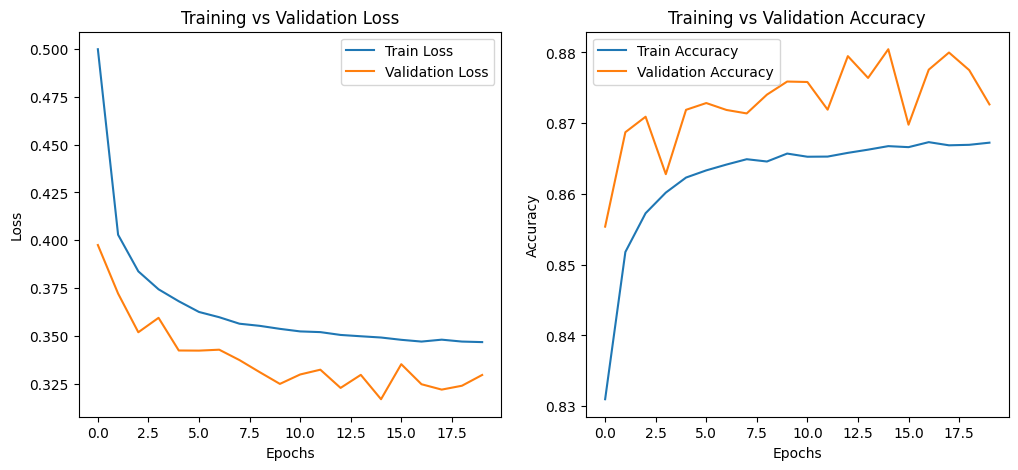

In [2]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset/updated_dataset .csv")  # Use your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target (Remove highly correlated features)
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday"])  
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# ✅ Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# ✅ Add Cluster Labels to Features
X_final = np.column_stack((X_pca, clusters))

# ✅ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Build ANN Model
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.05), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.05)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# ✅ Make Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# ✅ Print Metrics
print(f"ANN Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# ✅ Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()


# WITH FEATURE SELECTION

✅ Selected Features: ['YEAR', 'MO', 'T2M', 'T2M_MIN', 'RH2M', 'PRECTOTCORR', 'PS']
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5880/5880 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8275 - loss: 0.7256 - val_accuracy: 0.8658 - val_loss: 0.4110
Epoch 2/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8562 - loss: 0.4268 - val_accuracy: 0.8699 - val_loss: 0.3915
Epoch 3/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8603 - loss: 0.4105 - val_accuracy: 0.8738 - val_loss: 0.3875
Epoch 4/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8649 - loss: 0.3979 - val_accuracy: 0.8585 - val_loss: 0.3842
Epoch 5/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8660 - loss: 0.3891 - val_accuracy: 0.8804 - val_loss: 0.3631
Epoch 6/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8678 - loss: 0.3831 - val_accuracy: 0.8687 - val_loss: 0.3900
Epoch 7/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8674 - loss: 0.3810 - val_accuracy: 0.8791 - val_loss: 0.3580
Epoch 8/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8689 - loss: 0.3776 - val

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



🎯 ANN Accuracy: 0.8887
📌 Precision: 0.8812
📌 Recall: 0.9505
📌 F1-Score: 0.9145
📌 G-Mean: 0.8638
📌 ROC-AUC Score: 0.8677


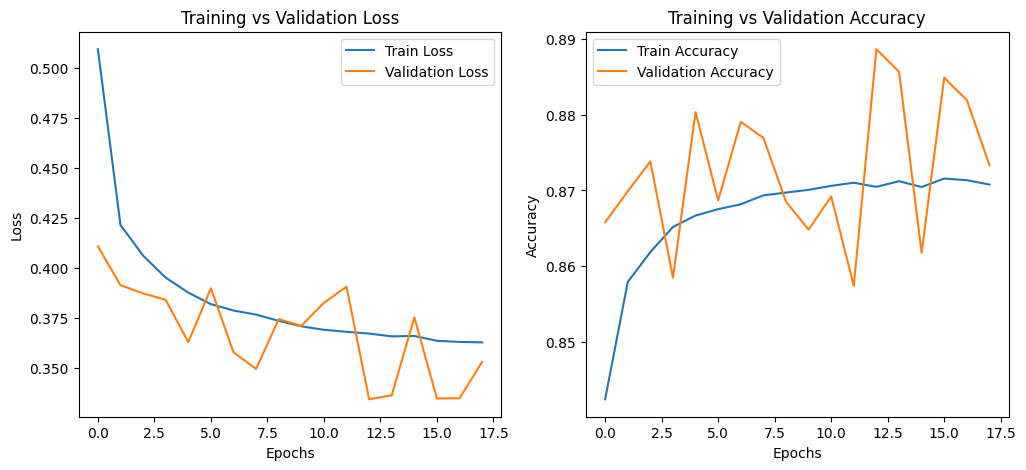

In [6]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset/updated_dataset .csv")  # Use your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday"])  
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Feature Selection using SelectKBest (Top 10 Features)
selector = SelectKBest(score_func=f_classif, k=7)
X_selected = selector.fit_transform(X_scaled, y)

# ✅ Get Selected Feature Names
selected_feature_names = X.columns[selector.get_support()]
print("✅ Selected Features:", list(selected_feature_names))

# ✅ Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_selected)

# ✅ Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# ✅ Add Cluster Labels to Features
X_final = np.column_stack((X_pca, clusters))

# ✅ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Build ANN Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.03), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# ✅ Make Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# ✅ Print Metrics
print(f"\n🎯 ANN Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-Score: {f1:.4f}")
print(f"📌 G-Mean: {g_mean:.4f}")
print(f"📌 ROC-AUC Score: {roc_auc:.4f}")

# ✅ Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()


✅ Selected Features: ['YEAR', 'T2M', 'T2M_MIN', 'RH2M', 'PRECTOTCORR', 'PS']
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5880/5880 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8909 - loss: 0.6235 - val_accuracy: 0.9293 - val_loss: 0.2632
Epoch 2/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9179 - loss: 0.2826 - val_accuracy: 0.9259 - val_loss: 0.2514
Epoch 3/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9211 - loss: 0.2639 - val_accuracy: 0.9261 - val_loss: 0.2453
Epoch 4/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9202 - loss: 0.2576 - val_accuracy: 0.9328 - val_loss: 0.2253
Epoch 5/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9199 - loss: 0.2533 - val_accuracy: 0.9315 - val_loss: 0.2252
Epoch 6/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9217 - loss: 0.2462 - val_accuracy: 0.9301 - val_loss: 0.2234
Epoch 7/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9216 - loss: 0.2441 - val_accuracy: 0.9318 - val_loss: 0.2151
Epoch 8/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9220 - loss: 0.2408 - val

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


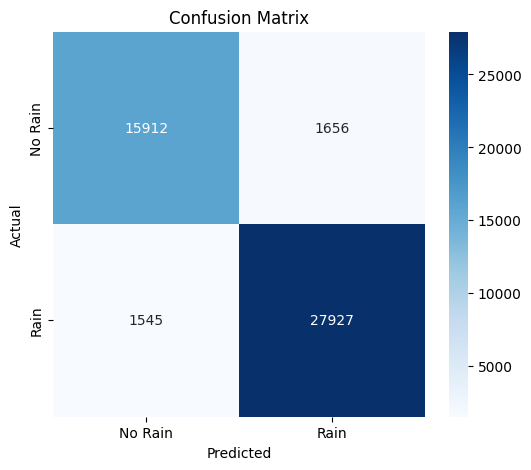

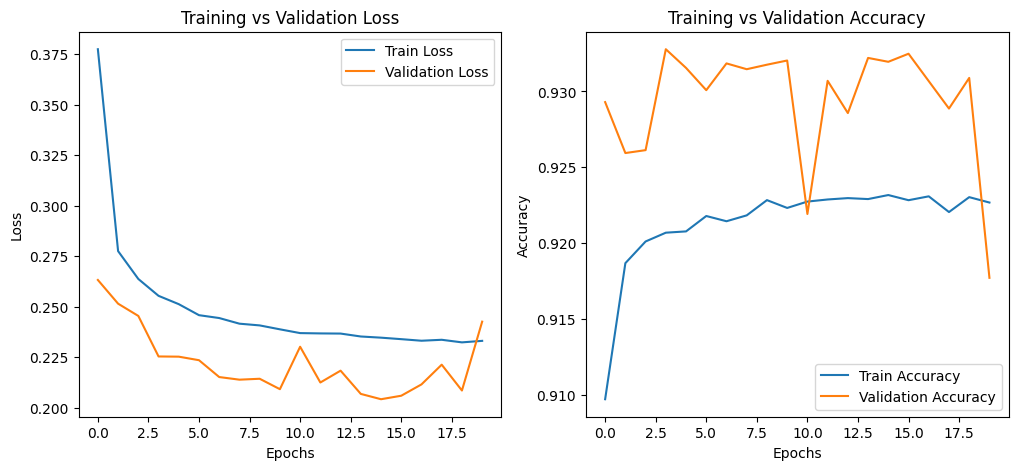

In [2]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset/updated_dataset .csv")  # Use your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday","MO"])  
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Feature Selection using SelectKBest (Top 7 Features)
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X_scaled, y)

# ✅ Get Selected Feature Names
selected_feature_names = X.columns[selector.get_support()]
print("✅ Selected Features:", list(selected_feature_names))

# ✅ Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_selected)

# ✅ Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# ✅ Add Cluster Labels to Features
X_final = np.column_stack((X_pca, clusters))

# ✅ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Build ANN Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.03), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# ✅ Make Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# ✅ Print Metrics
print(f"\n🎯 ANN Accuracy After Feature Selection: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-Score: {f1:.4f}")
print(f"📌 G-Mean: {g_mean:.4f}")
print(f"📌 ROC-AUC Score: {roc_auc:.4f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()


✅ Selected Features: ['T2M', 'T2M_MIN', 'RH2M', 'PRECTOTCORR', 'PS']
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5880/5880 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8980 - loss: 0.6094 - val_accuracy: 0.9286 - val_loss: 0.2657
Epoch 2/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9175 - loss: 0.2837 - val_accuracy: 0.9263 - val_loss: 0.2509
Epoch 3/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9190 - loss: 0.2671 - val_accuracy: 0.9291 - val_loss: 0.2362
Epoch 4/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9214 - loss: 0.2563 - val_accuracy: 0.9328 - val_loss: 0.2281
Epoch 5/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9208 - loss: 0.2508 - val_accuracy: 0.9247 - val_loss: 0.2340
Epoch 6/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9216 - loss: 0.2492 - val_accuracy: 0.9324 - val_loss: 0.2174
Epoch 7/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9210 - loss: 0.2444 - val_accuracy: 0.9301 - val_loss: 0.2188
Epoch 8/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9212 - loss: 0.2428 - val

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


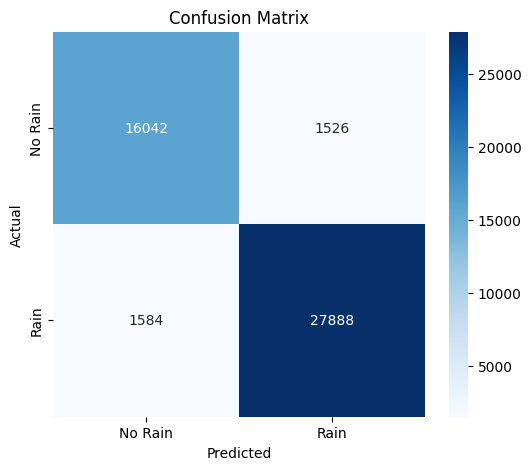

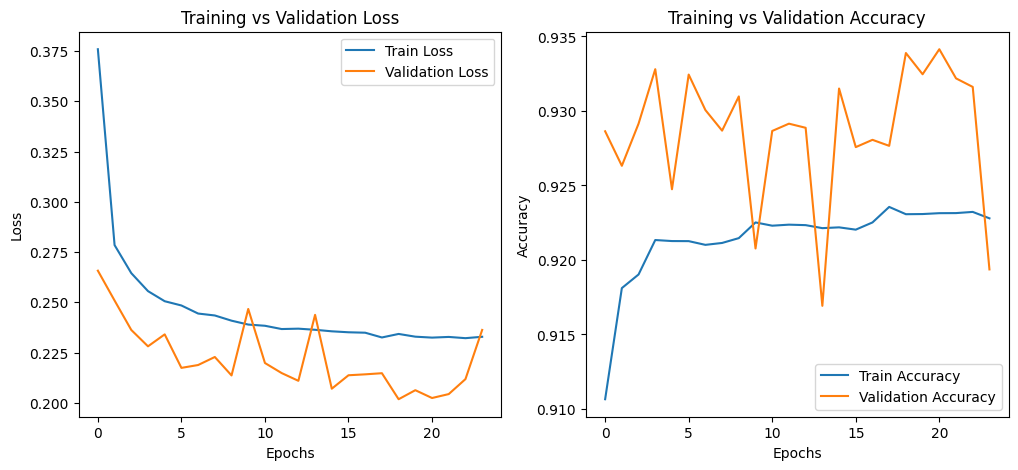

In [3]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset/updated_dataset .csv")  # Use your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday","MO","YEAR"])  
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Feature Selection using SelectKBest (Top 7 Features)
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X_scaled, y)

# ✅ Get Selected Feature Names
selected_feature_names = X.columns[selector.get_support()]
print("✅ Selected Features:", list(selected_feature_names))

# ✅ Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_selected)

# ✅ Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# ✅ Add Cluster Labels to Features
X_final = np.column_stack((X_pca, clusters))

# ✅ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Build ANN Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.03), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# ✅ Make Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# ✅ Print Metrics
print(f"\n🎯 ANN Accuracy After Feature Selection: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-Score: {f1:.4f}")
print(f"📌 G-Mean: {g_mean:.4f}")
print(f"📌 ROC-AUC Score: {roc_auc:.4f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()
